# Images

["jpg", "png", "jpeg", "tif", "tiff", "gif", "bmp"]

In [23]:
def ocr_image(im, app):
    """
    Extract text from an Image using Leptonica and tessetact
    params:
    im: PIL image
    app: FastAPI endpoint. Contains global objects with tesseract and Leptonica C objects
    return:
    text extracted
    """
    pix = pil2PIX32(im, app.leptonica, app.ffi)

    # Get information about DPI
    x_dpi = app.ffi.new("int *")
    y_dpi = app.ffi.new("int *")
    app.leptonica.pixGetResolution(pix, x_dpi, y_dpi)
    app.tesseract.TessBaseAPISetImage2(app.api, pix)
    app.tesseract.TessBaseAPIRecognize(app.api, app.ffi.NULL)
    # Print whole recognized text
    utf8_text = app.ffi.string(app.tesseract.TessBaseAPIGetUTF8Text(app.api)).decode(
        "utf-8"
    )
    return utf8_text


def extract_from_single_image(data, app):
    """
    Process imagenes and extract text via ocr
    params:
    data: list of documents from detect AI
    app global variables from FastAPI. contains tessetact and leptonica objects
    return:
    text extracted and endpoint
    """
    im_b64 = data.get("source").get("content")
    ext = data.get("source").get("file_type")

    img_bytes = base64.b64decode(im_b64.encode("utf-8"))
    # Open Image
    im = Image.open(io.BytesIO(img_bytes))
    if ext == "gif":
        mypalette = im.getpalette()
        im.putpalette(mypalette)
        new_im = Image.new("RGBA", im.size)
        new_im.paste(im)
        im = copy.deepcopy(new_im)
    # extract text
    utf8_text = ocr_image(im, app)
    data["source"]["content"] = utf8_text
    return utf8_text, data

# DOC and DOCX


https://pypi.org/project/docx2txt/

In [1]:
import docx2txt
import os
from PIL import Image

In [2]:
text = docx2txt.process("data/files/test_images.docx", 'data/doc_images/') 

# ODT

https://docs.python.org/3/library/zipfile.html

https://www.howtogeek.com/765461/what-is-an-odt-file-and-how-do-you-open-one/

In [4]:
import zipfile
from pathlib import Path

odt_file = 'data/files/test2.odt'

with zipfile.ZipFile(odt_file) as zf:
    # Get list of file names inside zip
    file_list = zf.namelist()  
    
    # Check for Pictures folder
    pictures_folder = 'Pictures'
    for file in file_list:
        if pictures_folder in file:

            print(f"Image in {file}")

        # Extract Pictures folder
            zf.extract(file, path="data/files")

Image in Pictures/100000000000060000000800CF5E489B17A34A69.jpg
Image in Pictures/100000000000060000000800D2FE211392241C57.jpg
Image in Pictures/100000000000060000000800FF81DC2E3B766582.jpg


# RTF and HTML

In [22]:
# https://www.gnu.org/software/unrtf

#  https://www.crummy.com/software/BeautifulSoup/

# https://pillow.readthedocs.io/en/stable/

In [6]:
import os
from bs4 import BeautifulSoup as BS
from PIL import Image

def convert_rtf_to_doc(input_file, output_file):

  os.system(f'unrtf --html {input_file} > {output_file}')


input_file = 'data/files/test.rtf'
output_file = 'data/files/test_rtf.html'

convert_rtf_to_doc(input_file, output_file)

In [7]:
# Open html and extract Images
with open(output_file) as html_wr:
    html_data = html_wr.read()

In [8]:
soup = BS(html_data, features="lxml")

In [9]:
images_arr = soup.find_all("img")

In [10]:
files=[]
for ind, i in zip(images_arr, range(len(images_arr))):
        files.append(ind["src"])

In [12]:
len(files)

3

In [13]:
for i, file in zip(range(len(files)), files):
        im = Image.open(os.path.join( file))
        # Extract text from Image

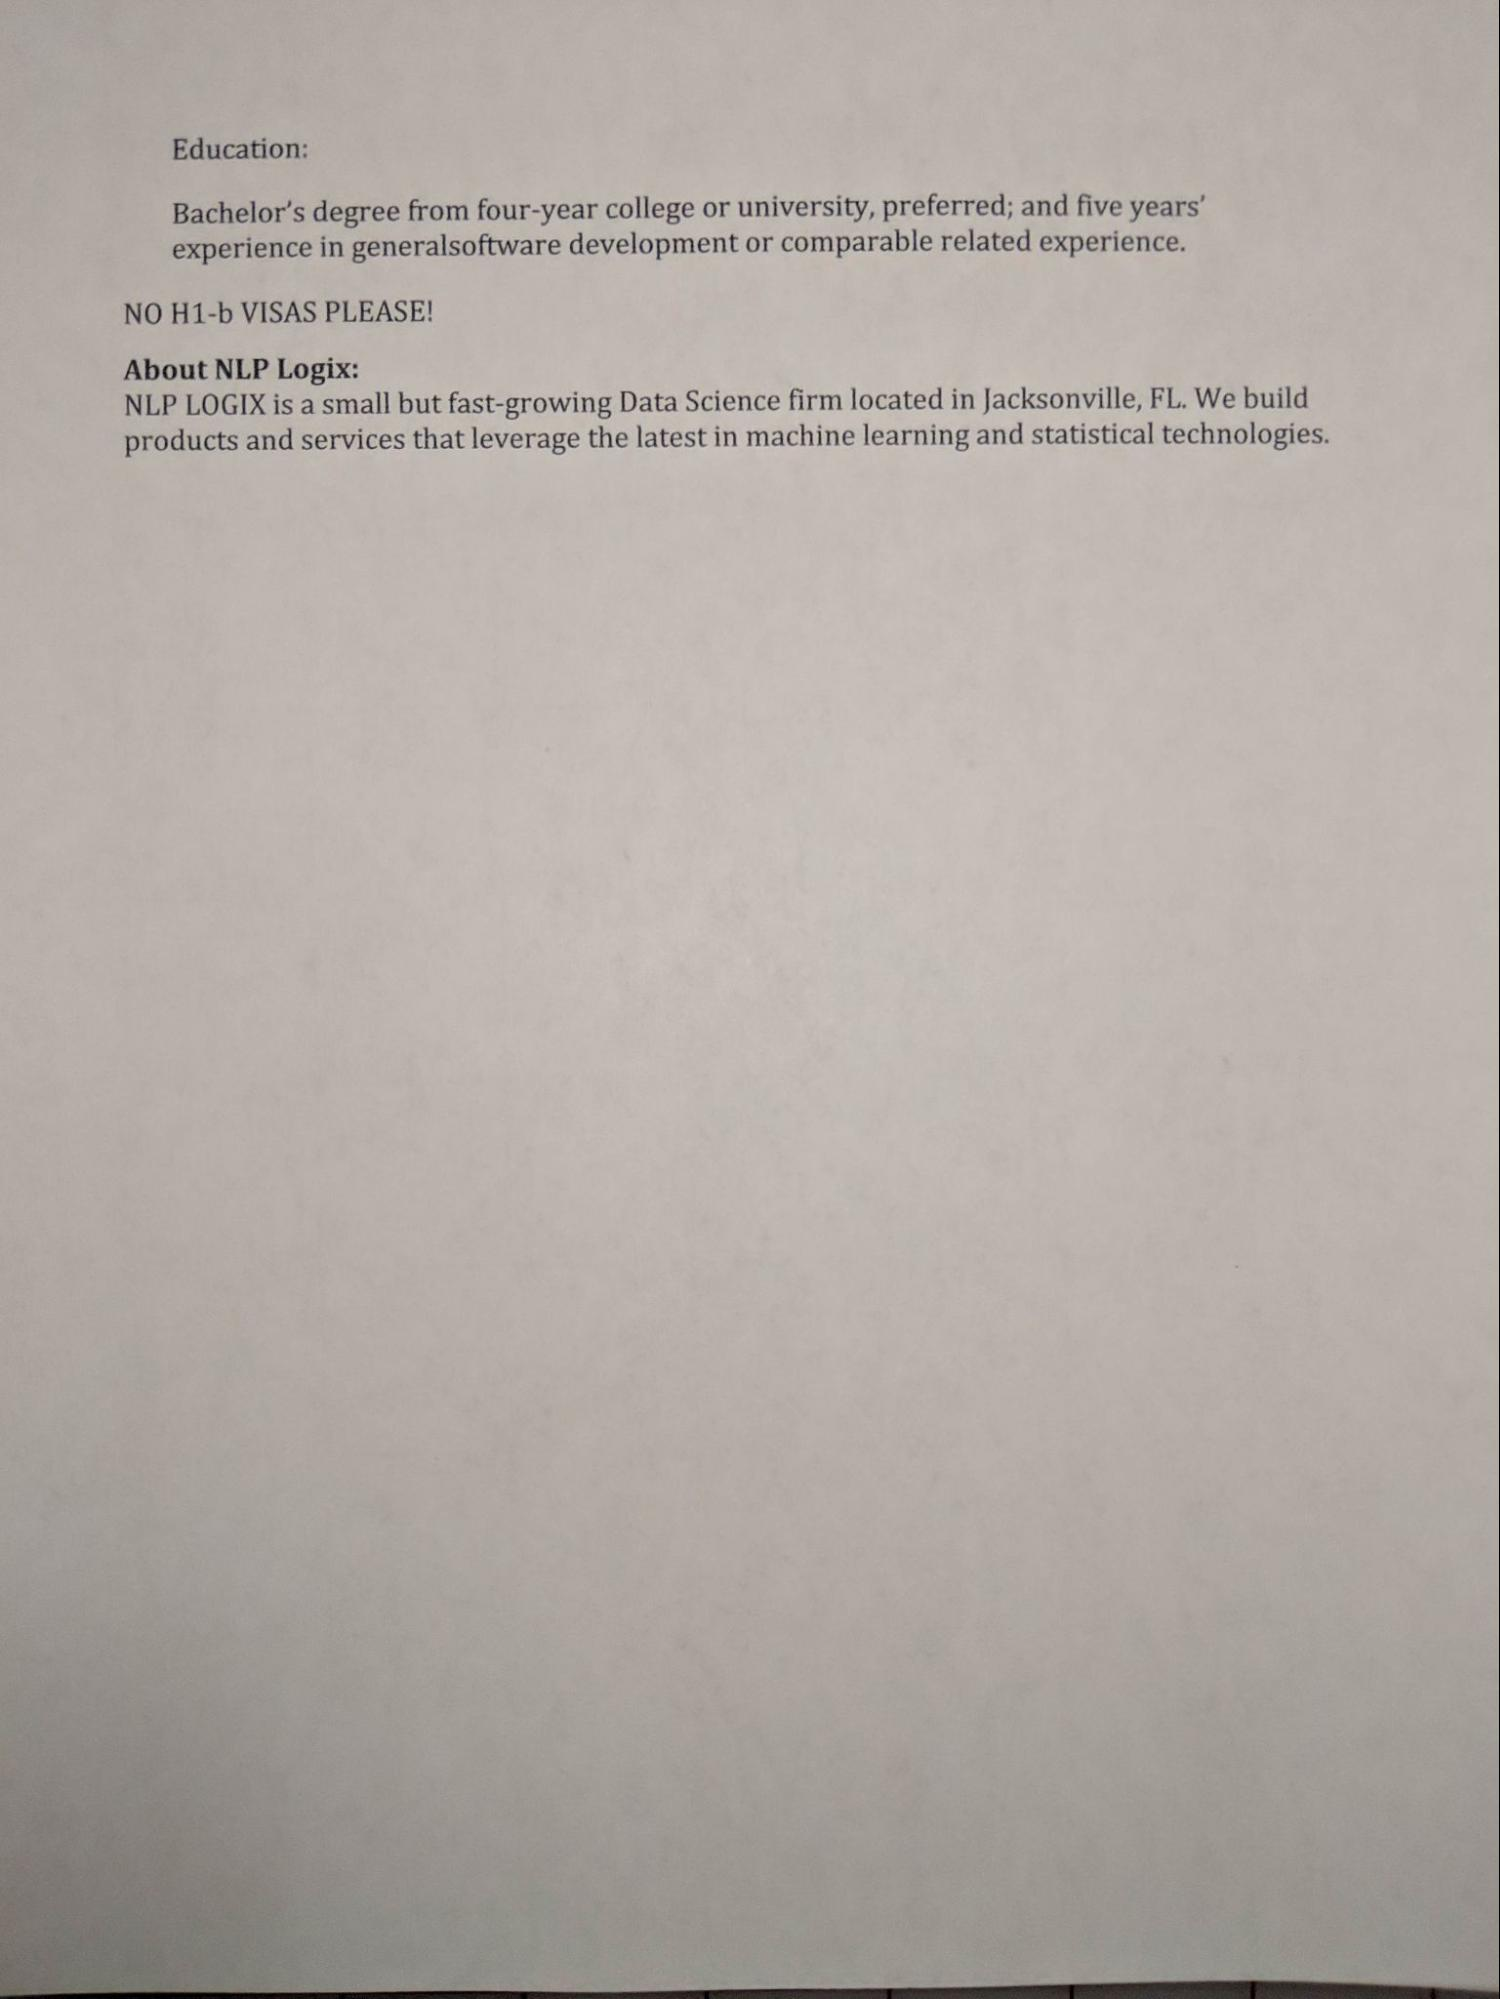

In [24]:
im

# ppt, pptx


https://github.com/scanny/python-pptx

In [16]:
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE

n=0
def write_image(shape):
    global n
    image = shape.image
    # ---get image "file" contents---
    image_bytes = image.blob
    # ---make up a name for the file, e.g. 'image.jpg'---
    image_filename = 'data/doc_images/ppt_image{:03d}.{}'.format(n, image.ext)
    n += 1
    print(image_filename)
    with open(image_filename, 'wb') as f:
        f.write(image_bytes)

def visitor(shape):
    if shape.shape_type == MSO_SHAPE_TYPE.GROUP:
        for s in shape.shapes:
            visitor(s)
    if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
        write_image(shape)

def iter_picture_shapes(prs):
    for slide in prs.slides:
        for shape in slide.shapes:
            visitor(shape)

In [19]:
filename = "data/files/test.pptx"

In [20]:
iter_picture_shapes(Presentation(filename))

data/doc_images/ppt_image000.jpg
data/doc_images/ppt_image001.jpg
data/doc_images/ppt_image002.jpg
